In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyart
import wradlib as wrl
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
radar = pyart.io.read('RODN19970817_020329')

In [3]:
radar.latitude['data'] = np.array([26.35])

In [4]:
radar.longitude['data'] = np.array([128])

In [5]:
display = pyart.graph.RadarMapDisplay(radar)
projection = ccrs.LambertConformal(radar.longitude['data'][0],radar.latitude['data'][0])

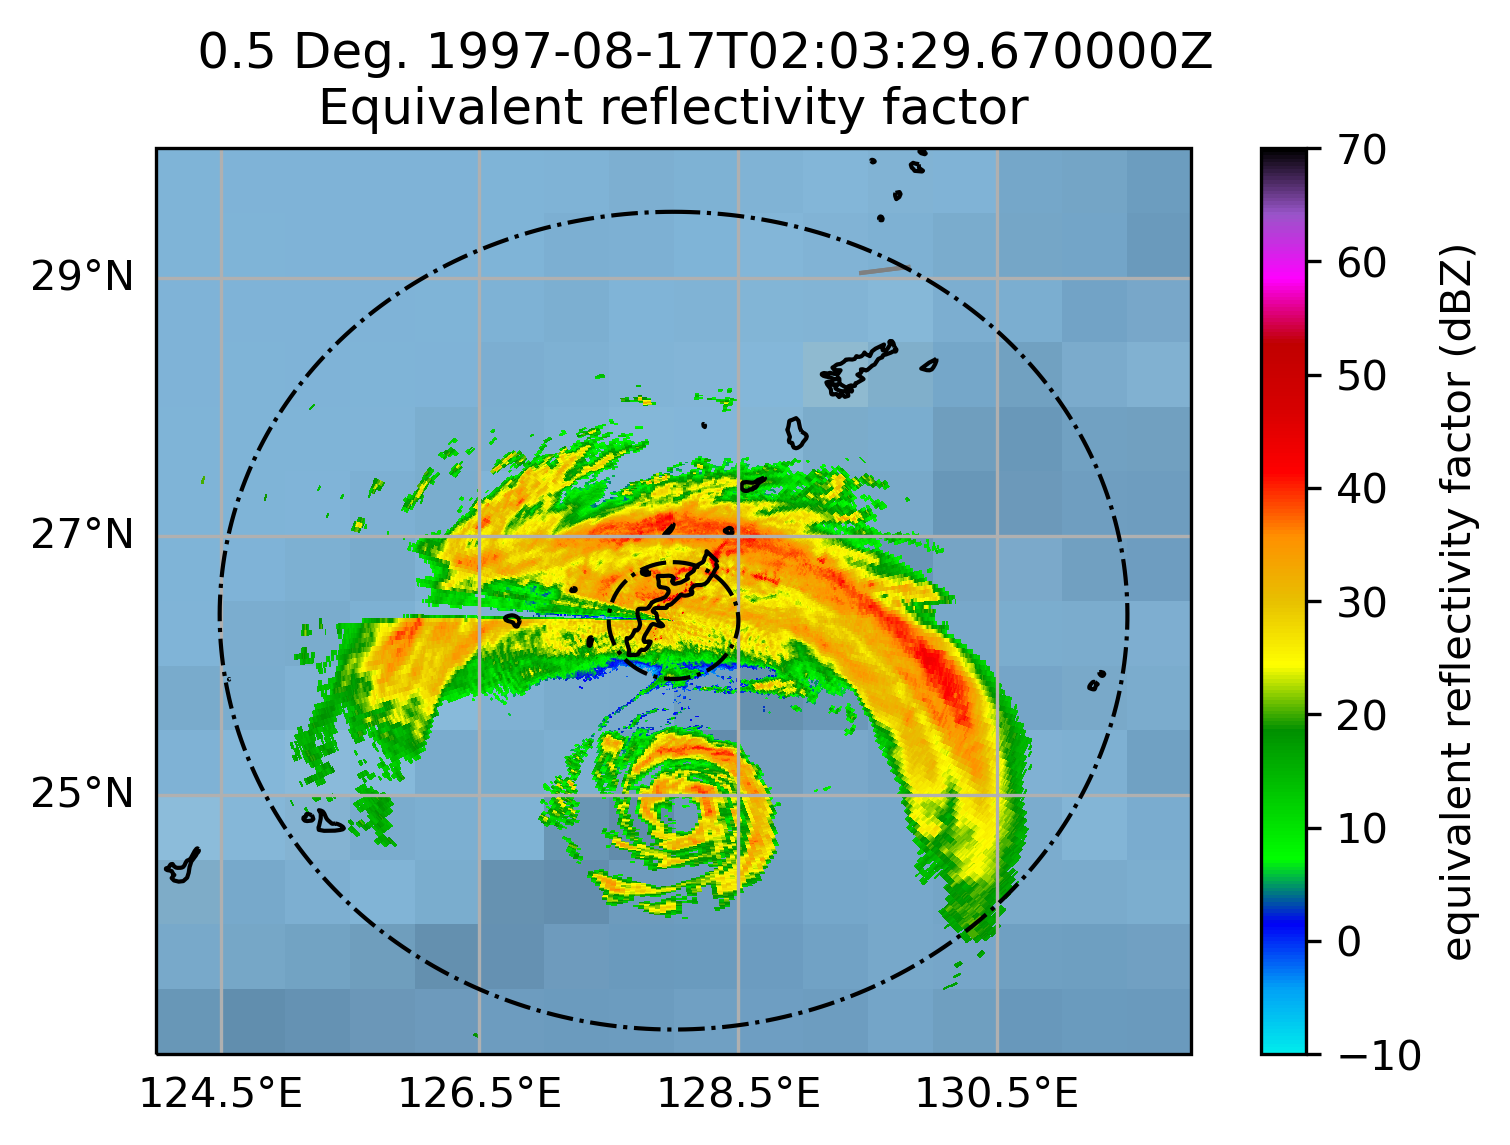

In [6]:
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
fig = plt.figure(dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([124,132,23,30])
ax.stock_img()
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')

# Add a text annotation for the license information to the
# the bottom right corner.
display.plot_ppi_map('reflectivity', sweep=0, resolution='10m',
                     vmin=-10, vmax=70,lon_lines=np.arange(124.5, 131.2,2), 
                     lat_lines=np.arange(23, 29.5, 2),
                     fig=fig, lat_0=radar.latitude['data'][0],
                     lon_0=radar.longitude['data'][0],
                     projection=ccrs.PlateCarree(), cmap='pyart_NWSRef',
                     )
display.plot_range_ring(50, line_style='k-.' ,lw='1')
display.plot_range_ring(350, line_style='k-.' ,lw='1')

In [7]:
# pyart.io.write_cfradial('RODN19970817_020329.nc',radar=radar,)

In [8]:
vol = wrl.io.open_cfradial1_dataset('RODN19970817_020329.nc')

In [9]:
swp = vol[0].pipe(wrl.georef.georeference_dataset)

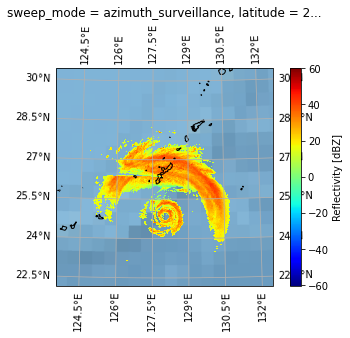

In [10]:
plt.figure()
ax = plt.subplot(projection=ccrs.AzimuthalEquidistant(central_longitude=swp.longitude.values,central_latitude=swp.latitude.values))
swp['reflectivity'].plot(x='x',y='y',cmap='jet')
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.stock_img()
ax.add_feature(feat.NaturalEarthFeature('cultural',name='admin_0_boundary_lines_land',scale='110m'),zorder=0)

In [11]:
import xarray as xr

In [12]:
print('Iterating over sweeps and stacking points')
swp_list = []
print('Creating 3D Grid')
for v in vol:
     # georeference and stack dimensions
    swp = v.pipe(wrl.georef.georeference_dataset).stack(points=["azimuth", "range"])
    swp_list.append(swp)
# concat sweeps to volume
vol0 = xr.concat(swp_list, dim="points")
# Create XYZ Coordinate DataArray
xyz = xr.concat([vol0.x, vol0.y, vol0.z], dim="xyz").transpose()
# Create Target 3D Grid
trgx = np.linspace(xyz[:, 0].min(),xyz[:, 0].max(), 500)
trgy = np.linspace(xyz[:, 1].min(),xyz[:, 1].max(), 500)
trgz = np.linspace(0, 20000, 40)
yy, hh, xx = np.meshgrid(trgy,trgz,trgx)
trgxyz = np.stack([xx.flatten(), yy.flatten(), hh.flatten()]).T
# Create Gridder/Interpolator
trgshape=xx.shape
gridder = wrl.vpr.CAPPI(polcoords=xyz,
                     gridcoords=trgxyz,
                     gridshape=trgshape,
                     maxrange=400000,
                     minelev=0,
                     maxelev=90,
                     ipclass=wrl.ipol.Nearest)
print('Interpolating Data into 3D Grids')
# Interpolate Data into 3D Grid

vol_zh = np.ma.masked_invalid(gridder(vol0.reflectivity.values).reshape(trgshape))
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]
print('Gridding Complete')
print('Plotting Max-Z')

Iterating over sweeps and stacking points
Creating 3D Grid
Interpolating Data into 3D Grids
Gridding Complete
Plotting Max-Z


In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

Text(0, 0.5, '')

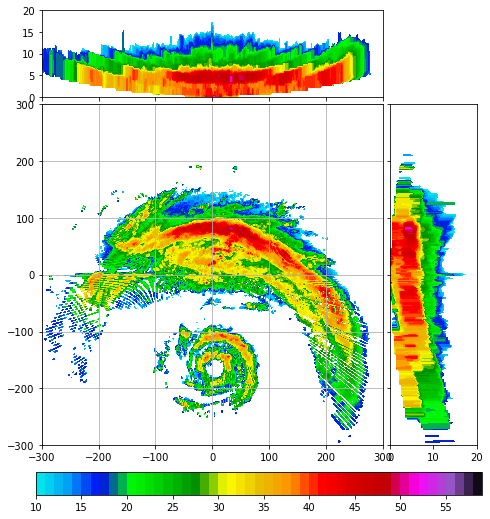

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1.)
abc=ax.contourf(trgx/1e3,trgy/1e3,vol_zh.max(axis=0),cmap='pyart_NWSRef',levels=range(10,60),)
plt.colorbar(abc,shrink=0.8,pad=0.05,location='bottom')
ax.grid()
ax.set_title(None)
ax.set_xlim(-3e2,3e2)
ax.set_ylim(-3e2,3e2)
# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_x = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_y = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
# make some labels invisible
ax_x.xaxis.set_tick_params(labelbottom=False)
ax_y.yaxis.set_tick_params(labelleft=False)
ax_x.contourf(trgx/1e3, trgz/1e3,vol_zh.max(axis=1),cmap='pyart_NWSRef',levels=range(10,60),add_colorbar=False)
ax_y.contourf(trgz/1e3, trgy/1e3,vol_zh.max(axis=2).T,cmap='pyart_NWSRef',levels=range(10,60),
                                         add_colorbar=False,add_title=None,)
ax_y.set_title(None)
ax_y.set_xlabel(None);ax_y.set_ylabel(None);ax_x.set_xlabel(None);ax_x.set_ylabel(None)
# fig.tight_layout()